# McStas data to MJOLNIR data format, conversion script for BIFROST

by: Kristine M. L. Krighaar

created: 18/01/2024

In [5]:
from KGS import * # Utilizing my own package for data analysis. Remember to also send enviroment when sharing. 
import scipp as sc
import scippneutron as scn
from scippneutron.conversion import graph
import os
from IPython.display import Image
import h5py
import sys
from TubeMeasurment_txt_file import tube_measurement


## Data reduction process

Full overview of how converison is done: 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (100, 1000)


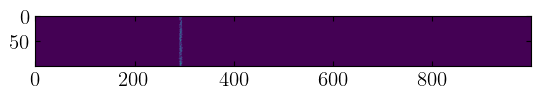

In [24]:

filename = '../McStasScript/data_folder/bifrost_62'
wedge = 0
arc = 4
tube = 0

I = np.loadtxt(str(filename)+'/signal_1Dspace_'+str(wedge)+'_'+str(arc)+'_'+str(tube)+'.dat').reshape(3,1000,100)[0]
I = I.T
I_err = np.loadtxt(str(filename)+'/signal_1Dspace_'+str(wedge)+'_'+str(arc)+'_'+str(tube)+'.dat').reshape(3,1000,100)[1]
I_err = I_err.T

file = str(filename)+'/signal_1Dspace_'+str(wedge)+'_'+str(arc)+'_'+str(tube)+'.dat'

with open(file, 'r') as the_file:
    all_data = [line.strip() for line in the_file.readlines()]
    limits = all_data[28]
    limits = limits.replace('# xylimits: ', '')
    limits = limits.split(' ')
    limits = np.asarray(limits, dtype=float)
    t_s = np.linspace(limits[2], limits[3], 1000)
    y_m = np.linspace(limits[0], limits[1], 100)
    A4 = all_data[9]
    A4 = A4.replace('# Param: A4=', '')
    A4_offset = np.asarray(A4).astype('float')

    A3 = all_data[10]
    A3 = A3.replace('# Param: A3=', '')
    A3 = np.asarray(A3).astype('float')

# Scipp binning of one instrument setting

## Importing all tubes for a given A3, A4 setting.

In [19]:

settings = tube_measurement.load_Backend_measurment('../McStasScript/data_folder/bifrost_62')

print('Estimated memory size of a Backend measurment =',sys.getsizeof(settings)/1024, 'kB')

Estimated memory size of a Backend measurment = 0.078125 kB


## Exporting dataformat for MJOLNIR

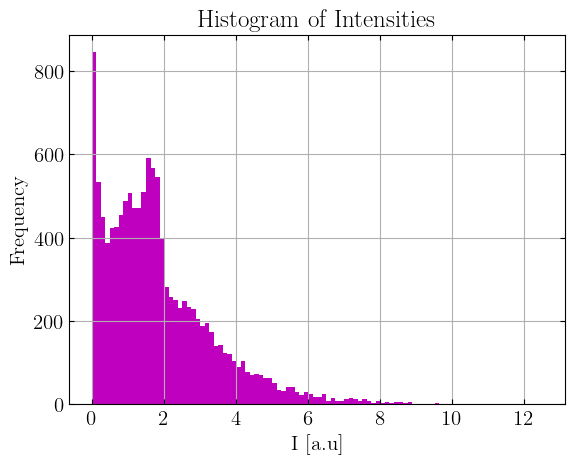

In [20]:
data_flat = settings[0]

# Create a histogram
plt.hist(data_flat[(data_flat>0.01)], bins=100, color='m')  # Adjust the number of bins as needed
plt.xlabel('I [a.u]')
plt.ylabel('Frequency')
plt.title('Histogram of Intensities')
plt.grid(True)
plt.show()

In [21]:

"""
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot data: I, I_err, DeltaE, qx, qy
ax.scatter(settings[3], settings[4], settings[2], c=settings[0])

ax.set_xlabel('qx')
ax.set_ylabel('qy')
ax.set_zlabel('DeltaE')
ax.set_title('tube measuring surface')
plt.show()
"""

"\nfig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\n\n# Plot data: I, I_err, DeltaE, qx, qy\nax.scatter(settings[3], settings[4], settings[2], c=settings[0])\n\nax.set_xlabel('qx')\nax.set_ylabel('qy')\nax.set_zlabel('DeltaE')\nax.set_title('tube measuring surface')\nplt.show()\n"

In [22]:


qx = sc.array(dims=["row"], values=settings[3], unit="Å^(-1)")
qy = sc.array(dims=["row"], values=settings[4], unit="Å^(-1)")
deltaE = sc.array(dims=["row"], values=settings[2], unit="meV")
Q = sc.array(dims=["row"], values=np.sqrt(settings[3]**2+settings[4]**2), unit="Å^(-1)")

recording = sc.DataArray(
    data=sc.array(dims=["row"], values=settings[0], unit="Å^(-1)", variances=settings[1]), 
    coords={"qx": qx, "qy": qy, "deltaE":deltaE, "Q":Q}
)

sliced = recording.bin(qx=400, qy=400, deltaE=300)
slicedQ = recording.bin(deltaE=500, Q=400)

sc.show(sliced)
sliced = sliced.bins.mean()
sliced

slicedQ = slicedQ.bins.mean()
slicedQ

<scipp.DataArray>
Dimensions: Sizes[deltaE:500, Q:400, ]
Coordinates:
* Q                         float64           [1/Å]  (Q [bin-edge])  [0.461247, 0.475251, ..., 6.04889, 6.06289]
* deltaE                    float64            [meV]  (deltaE [bin-edge])  [-3.45462, -3.33095, ..., 58.2595, 58.3832]
Data:
                            float64           [1/Å]  (deltaE, Q)  [nan, nan, ..., 0, 0]  [nan, nan, ..., 0, 0]

/Users/kristinekrighaar/opt/anaconda3/lib/python3.9/site-packages/scipp/core/deprecation.py:7: VisibleDeprecationWarning: sc.DataArray.attrs has been deprecated and will be removed in Scipp v24.12.0. The deprecation includes sc.DataArray.meta and sc.DataArray.drop_attrs. For unaligned coords, use sc.DataArray.coords and unset the alignment flag. For other attributes, use a higher-level data structure.
  warnings.warn(


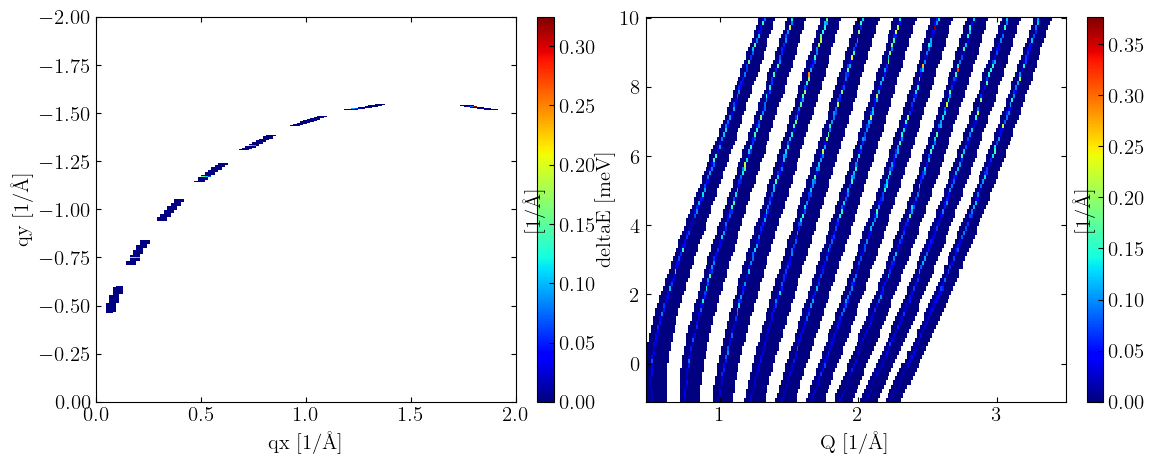

In [23]:
E_layer = 0 * sc.Unit('meV')
qy_layer = -1.53 * sc.Unit('Å^(-1)')

E_min = -1 * sc.Unit('meV')
E_max = 10 * sc.Unit('meV')

Q_min = 0 * sc.Unit('Å^(-1)')
Q_max = 3.5 * sc.Unit('Å^(-1)')

qx_min = 0 * sc.Unit('Å^(-1)')
qx_max = 2 * sc.Unit('Å^(-1)')

qy_min = -3.0 * sc.Unit('Å^(-1)')
qy_max = 3.0 * sc.Unit('Å^(-1)')

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
p1 = sliced['deltaE', E_layer]['qy', qy_min:qy_max].transpose().plot(ax=ax[0], cmap='jet')
ax[0].set_xlim(0,2)
ax[0].set_ylim(-0,-2)
#p2 = sliced['deltaE', E_min:E_max]['qy', qy_layer].transpose().plot(ax=ax[1], cmap='jet')
p3 = slicedQ['deltaE', E_min:E_max]['Q',Q_min:Q_max].plot(ax=ax[1], cmap='jet')